In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:3]:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/img_circle_target/AF219.jpg
/kaggle/input/img_circle_target/AM254.jpg
/kaggle/input/img_circle_target/AF1432.jpg
/kaggle/input/img_circle/AF219.jpg
/kaggle/input/img_circle/AM254.jpg
/kaggle/input/img_circle/AF1432.jpg


In [2]:
import time

from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.utils
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [3]:
PATH_Y='/kaggle/input/img_circle_target/'
PATH_TRAIN='/kaggle/input/img_circle/'
batch_size = 16
HIDDEN_SIZE=1000
ind = np.array(list(range(len(os.listdir(PATH_TRAIN)))))
np.random.shuffle(ind)
sample_train=dict(zip(list(range(int(len(ind)*0.8))),np.array(os.listdir(PATH_TRAIN))[ind[:int(len(ind)*0.8)]]))
sample_test=dict(zip(list(range(int(len(ind)*0.2))),np.array(os.listdir(PATH_TRAIN))[ind[int(len(ind)*0.8):]]))


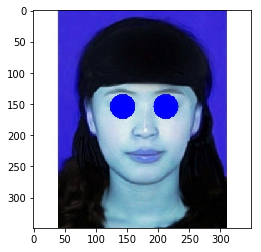

In [4]:
plt.imshow(cv2.imread(PATH_TRAIN+'AF1.jpg'))

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DetectionDataset(torch.utils.data.Dataset):
    
    def __init__(self, sample,size):
        self.sample=sample    
        self.size=size
    def __len__(self):
        return len(self.sample)
    
    def __getitem__(self, idx):
        img = cv2.imread(PATH_TRAIN+self.sample[idx])[:,:,::-1]
        img = DetectionDataset.preprocess_img(img,self.size)
        y = cv2.imread(PATH_Y+self.sample[idx])[:,:,::-1]
        y = DetectionDataset.preprocess_img(y,self.size)
        return img,y
    
    @staticmethod
    def preprocess_img(img,dsize=(350,350)):
        img = cv2.resize(img, dsize)
        img = img.astype(np.float32)
        img =(img-127.5)/127.5
        img = np.moveaxis(img, -1, 0)
        return torch.Tensor(img)

In [6]:
dataset_350 = DetectionDataset(sample=sample_train,size=(350,350))
trainloader_350 = torch.utils.data.DataLoader(dataset_350, batch_size=batch_size,
                                          shuffle=True, num_workers=0, drop_last=True)
dataset_175 = DetectionDataset(sample=sample_train,size=(175,175))
trainloader_175 = torch.utils.data.DataLoader(dataset_175, batch_size=batch_size,
                                          shuffle=True, num_workers=0, drop_last=True)
dataset_80 = DetectionDataset(sample=sample_train,size=(80,80))
trainloader_80 = torch.utils.data.DataLoader(dataset_80, batch_size=batch_size,
                                          shuffle=True, num_workers=0, drop_last=True)

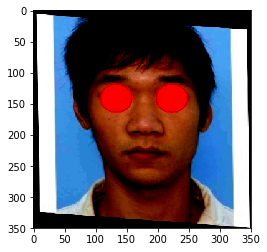

In [7]:
for x in trainloader_350:
    plt.imshow(x[0][0].permute(1,2,0))
    break

In [8]:
datasett_350 = DetectionDataset(sample=sample_test,size=(350,350))
testloader_350 = torch.utils.data.DataLoader(datasett_350, batch_size=batch_size,
                                          shuffle=True, num_workers=0, drop_last=True)
datasett_175 = DetectionDataset(sample=sample_test,size=(175,175))
testloader_175 = torch.utils.data.DataLoader(datasett_175, batch_size=batch_size,
                                          shuffle=True, num_workers=0, drop_last=True)
datasett_80 = DetectionDataset(sample=sample_test,size=(80,80))
testloader_80 = torch.utils.data.DataLoader(datasett_80, batch_size=batch_size,
                                          shuffle=True, num_workers=0, drop_last=True)

In [9]:
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()


        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv11 = nn.Conv2d(64,64, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128 )
        self.conv22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(128 )
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        self.conv4d = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn4d = nn.BatchNorm2d(256)
        
        self.conv3d = nn.Conv2d(256,  128, kernel_size=3, padding=1)
        self.bn3d = nn.BatchNorm2d(128)
        
        self.conv3dd = nn.Conv2d(128,  128, kernel_size=3, padding=1)
        self.bn3dd = nn.BatchNorm2d(128)
        self.dropout1=nn.Dropout2d(0.3)
        
        self.conv2d = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn2d = nn.BatchNorm2d(64)
        self.conv2dd = nn.Conv2d(64,64, kernel_size=3, padding=1)
        self.bn2dd = nn.BatchNorm2d(64)
        self.conv1d = nn.Conv2d(64, 3, kernel_size=3, padding=1)


    def forward(self, x):

        # Stage 1
        x1 = self.bn1(F.relu(self.conv1(x)))
        x1 = self.bn11(F.relu(self.conv11(x1)))

        x1p, id1 = F.max_pool2d(x1,kernel_size=2, stride=2,return_indices=True)
        x2 = self.bn2(F.relu(self.conv2(x1p)))
        x2 = self.bn22(F.relu(self.conv22(x2)))

        x2p, id2 = F.max_pool2d(x2,kernel_size=2, stride=2,return_indices=True)

        x3 = self.bn3(F.relu(self.conv3(x2p)))
        x3p, id3 = F.max_pool2d(x3,kernel_size=2, stride=2,return_indices=True)

        x4 = self.bn4(F.relu(self.dropout1(self.conv4(x3p))))
    #
        x4d = self.bn4d(F.relu(self.conv4d(x4)))

    
        x3d = F.max_unpool2d(x4d, id3, kernel_size=2, stride=2,output_size=x3.size())
        x3d = self.bn3d(F.relu(self.conv3d(x3d)))
        x3d = self.bn3dd(F.relu(self.conv3dd(x3d)))
        
        x2d = F.max_unpool2d(x3d, id2, kernel_size=2, stride=2,output_size=x2.size())
        x2d = self.bn2d(F.relu(self.conv2d(x2d)))
        x2d = self.bn2dd(F.relu(self.conv2dd(x2d)))

        x1d = F.max_unpool2d(x2d, id1, kernel_size=2, stride=2,output_size=x1.size())
        x1d = F.tanh(self.conv1d(x1d))
        return x1d
       
net = Net()
#net.change_derivative(100)
net.to(device)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn22): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_runni

In [ ]:
net(torch.rand(64,3,23,23)).size()

In [10]:
loss_function = nn.MSELoss()

In [11]:
criterion = loss_function
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [12]:
train_loss=[]
test_loss=[]

In [13]:
all_data=dict(zip([0,1,2],list(zip([trainloader_350,trainloader_175,trainloader_80],[testloader_350,testloader_175,testloader_80]))))

In [22]:
train_loss=[]
test_loss=[]

In [25]:
for e in range(1,20):
    running_loss=0
    test_los=0
    for w in range(136*2):
        ii=np.random.randint(3)
        for i, data in enumerate(all_data[ii][0], 1):
            inputs = data[0].to(device)
            labels = data[1].to(device)
            #labels = labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)

            loss = criterion(outputs, labels)#,mean,cov)
            loss.backward()
            optimizer.step()


            running_loss += loss.item()
            break
    for w in range(34*2):
        ii=np.random.randint(3)
        for i, data in enumerate(all_data[ii][1], 1):
            inputs = data[0].to(device)
            labels = data[1].to(device)

            outputs = net(inputs)

            loss = criterion(outputs, labels)#,mean,cov)
            loss.backward()

            test_los += loss.item()
            break
    test_loss.append(test_los / (34))
    train_loss.append(running_loss / (136))
    if e%5==0:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr']/5
    print(e,'Train',train_loss[-1],"Test ",test_loss[-1])

1 Train 0.010265203795450576 Test  0.011624384787864983
2 Train 0.009445924690226093 Test  0.009742503746083993
3 Train 0.009689051866777898 Test  0.008791546549593262
4 Train 0.009271261164137875 Test  0.009180033990346333
5 Train 0.009447079853784731 Test  0.008795215898905607
6 Train 0.00774867129032774 Test  0.008555480210548815
7 Train 0.007829414086539628 Test  0.008244514794034116
8 Train 0.007900374215644072 Test  0.00806881655829356
9 Train 0.007526716753251522 Test  0.008727237506879164
10 Train 0.00783724280378973 Test  0.007485335802330691
11 Train 0.008055120573879 Test  0.007991284330594628
12 Train 0.007360035380663569 Test  0.006578629935735508
13 Train 0.007602482149891062 Test  0.0077516987563713505
14 Train 0.0075054109842954755 Test  0.007897307069095619
15 Train 0.007703888127306367 Test  0.009201719692689092
16 Train 0.007328440702301176 Test  0.0073756373911986455
17 Train 0.007223620059769875 Test  0.007945555169820128
18 Train 0.007724549729198984 Test  0.00840

In [37]:
x=[]
for y in testloader_350:
    x=y[:2][0]
    break

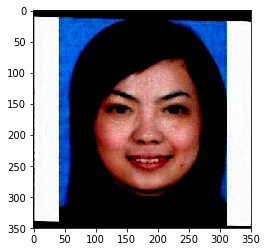

In [38]:
#net.eval()
plt.imshow(net(x.to(device))[1].cpu().detach().permute(1,2,0))

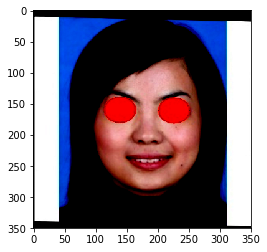

In [39]:
plt.imshow(x[1].permute(1,2,0))

In [ ]:
x.unsqueeze(0).size()

In [ ]:
net(torch.rand(3,3,250,250))

In [ ]:
if e%15==0:
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr']/2

In [ ]:
net.change_derivative(9)

In [40]:
torch.save(net.state_dict(), 'finnaaal_for_blue_eyes')

In [41]:
from IPython.display import FileLink
FileLink('finnaaal_for_blue_eyes')

/kaggle/working/finnaaal_for_blue_eyes

In [ ]:
np.savetxt('trainn.txt',train_loss)
np.savetxt('testt.txt',test_loss)

In [ ]:
from IPython.display import FileLink
FileLink('testt.txt')

In [ ]:
plt.plot(test_loss)